# import libraries

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import sys
from global_land_mask import globe
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
# import cases_lookup as CL
import pandas as pd
import utils_v1v2 as v1v2
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from scipy.stats import ttest_rel

import matplotlib as mpl
mpl.rcParams['font.size'] = 13
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams["legend.handlelength"] = 1.0
mpl.rcParams["legend.frameon"] = True

workdir = '/home/qin4/From_Compy/home_dir/'
datadir0 = '/p/user_pub/climate_work/qin4/From_Compy/compyfs_dir/'
figdir = workdir+'/scripts/published/figure/' 

# fixed parameters 
dt = 1800 # time step unit: s
cpair = 1.00464e3 #J/(kg K)
rho_w = 1000 # kg/m3
gravit = 9.8 # m/s2

from datetime import date
today = date.today()
dd = today.strftime("%Y-%m-%d")
print(dd)

2023-10-02


# read omega700_mm

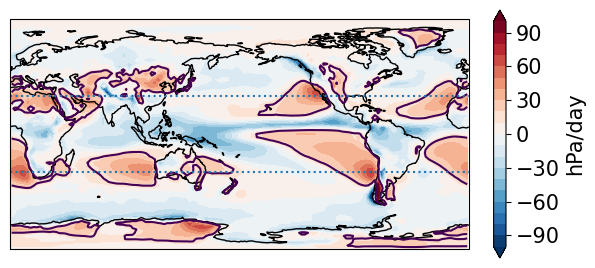

In [4]:

ff = xr.open_dataset('omega700_mm.nc')
omega700_pi_mm  = ff['omega700_pi_mm']
omega700_ab_mm  = ff['omega700_ab_mm']
omega700_avg_mm = ff['omega700_avg_mm']
ff.close()

# =========== check spatial map 
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(180.))

datap = omega700_pi_mm

im = ax.contourf(datap.lon,datap.lat,datap,transform=ccrs.PlateCarree(),
                cmap='RdBu_r',
                levels=np.arange(-100,110,10),
                extend='both')

ax.contour(datap.lon,datap.lat,datap,transform=ccrs.PlateCarree(),
           levels=[15])
ax.coastlines()
ax.set_global()

fig.colorbar(im,fraction=0.025,label='hPa/day')

ax.axhline(y=30,ls=':')
ax.axhline(y=-30,ls=':')

# define cases

In [6]:
case_stamp = [\
'v2.OutTend',\
'v2.bk.trig',\
'v1',\
]

case_stamp_out = [
    'v2',
    'v2.v1(ZMtrig)',
    'v1',
]

colorsh = v1v2.get_color('tab10',len(case_stamp_out))

tag = 'v2.vs.trig'

focus_region = 'TropMarineLow' # MarineLow, MidLat

# defined regions 
latS = -30
latE = -10
lonS = 240
lonE = 280 

do_spc_region = True

if do_spc_region:
    tag3 = 'SelectedDomain'
else:
    tag3 = 'AllRegime'
    
# new norm for colorbar
norm=v1v2.StretchOutNormalize(vmin=-3, vmax=3, low=-0.2, up=0.2)

# Figure 4 - cloud profile

/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_CLOUD_v2.OutTend.nc
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_CLOUD_v2.bk.trig.nc
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_CLOUD_v1.nc
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_CLDLIQ_v2.OutTend.nc
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_CLDLIQ_v2.bk.trig.nc
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
do_spc_region... -30 -10 240 280
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_CLDLIQ_v1.nc
do_spc_region... -30 -10 2

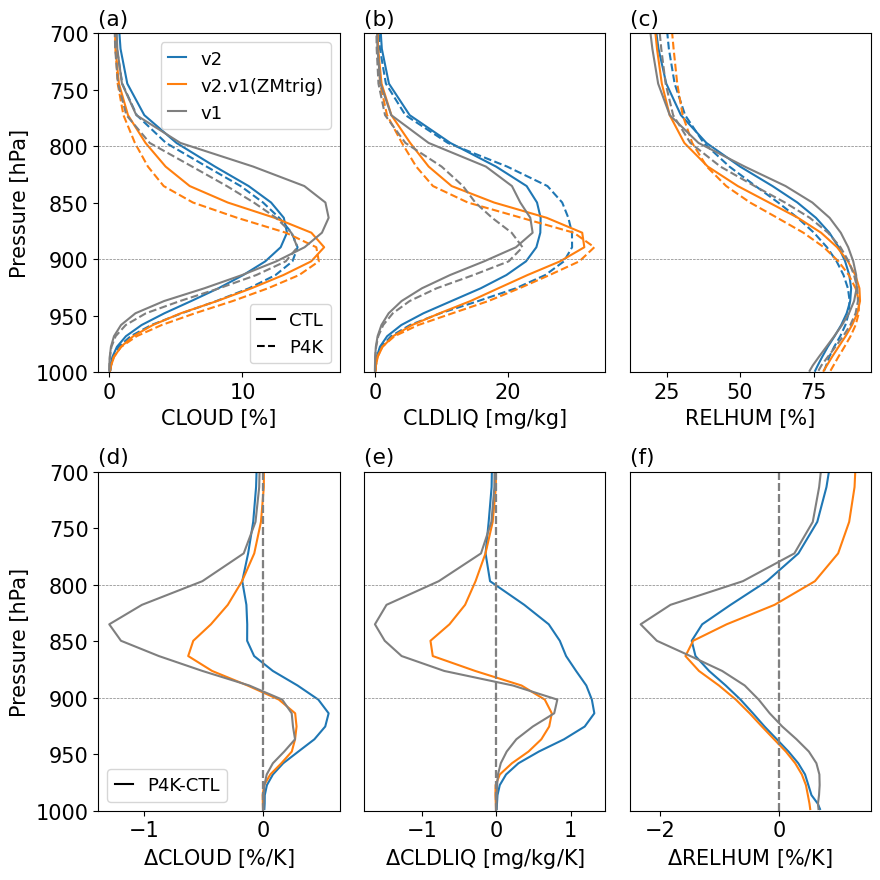

In [9]:
focus_region = 'TropMarineLow'
# focus_region = 'TropAscent'

do_spc_region = True

if focus_region == 'TropMarineLow':
    top_lev = 600
else:
    top_lev = 0 
    
case_stamp = [
    'v2.OutTend',
    'v2.bk.trig',
    'v1',
]

case_stamp_out = [
    'v2',
    'v2.v1(ZMtrig)',
    'v1',
]

VarsA = [
    ['CLOUD','%'],
    ['CLDLIQ','mg/kg'],
    ['RELHUM','%'],
    # ['T','K'],
    # ['Q','kg/kg'],
    # ['OMEGA','hPa/day'],
]

colorsh = [
    'tab:blue',
    'tab:orange',
    'tab:grey',
]

Vars = [svar[0] for svar in VarsA]
Vars_units = [svar[1] for svar in VarsA] 

       
# ================ read data ========================
datadir = workdir+'diag_feedback_E3SM/data/'

dics = {}
for svar in Vars:
    dics[svar] = {}
    for icase,case in enumerate(case_stamp):
        f1 = xr.open_dataset(datadir+'global_'+svar+'_'+case+'.nc')
        print(datadir+'global_'+svar+'_'+case+'.nc')
        data1 = f1[svar+'_pi_clim']
        data2 = f1[svar+'_ab_clim']
        data3 = f1[svar+'_ano_clim']
        
        dics[svar][case] = [] 
        for data in [data1,data2,data3]:
            
            # ensure the lat and lon names 
            latnew, lonnew = list(data.coords.keys())[0], list(data.coords.keys())[1]
            data = data.rename({lonnew: 'lon',latnew: 'lat'})

            _,_,data_avg,_,_,datam_avg,_ \
                = v1v2.regime_partitioning(focus_region,omega700_pi_mm,omega700_ab_mm,omega700_avg_mm,data)
            
            if focus_region == 'TropMarineLow' and do_spc_region:
                print('do_spc_region...',latS,latE,lonS,lonE)
                dics[svar][case].append(v1v2.area_averager(data_avg.sel(lat=slice(latS,latE),lon=slice(lonS,lonE))))
            else:
                dics[svar][case].append(v1v2.area_averager(data_avg))
            # print(data_avg.coords)
        
print(dics.keys())

# =============== Plot cloud profiles ================
nrow = 2
ncol = len(Vars)
fig = plt.figure(figsize=(12/4*ncol,9))

# top_lev = 600
bot_lev = 1000

for ivar,svar in enumerate(Vars):
    
    ax = fig.add_subplot(nrow,ncol,ivar+1)
    axd = fig.add_subplot(nrow,ncol,ivar+1+len(Vars))
    
    LLa = [] 
    for icase,case in enumerate(dics[svar].keys()):
        [data1, data2, data3] = dics[svar][case]
    
        if svar in ['RCM_CLUBB','RCMINLAYER_CLUBB']:
            scale = 1e3 # change from kg/kg to g/kg
        elif svar == 'CLDLIQ':
            scale = 1e6 # kg/kg -> mg/kg 
        elif svar == 'OMEGA':
            scale = 864 # change from Pa/s to hPa/day 
        elif svar == 'CLOUD':
            scale = 100 # fraction -> %
        else:
            scale = 1.0
            
        data1p = data1.sel(lev=slice(bot_lev,top_lev)) * scale
        data2p = data2.sel(lev=slice(bot_lev,top_lev)) * scale 
        data3p = data3.sel(lev=slice(bot_lev,top_lev)) * scale 
        
        if icase == 0:
            label_1 = 'CTL'
            label_2 = 'P4K'
            label_3 = 'P4K-CTL'
        else:
            label_1 = '_nolegend_'
            label_2 = '_nolegend_'
            label_3 = '_nolegend_'
            
        LL = ax.plot(data1p,data1p.lev,color=colorsh[icase],ls='-',label=label_1)
        ax.plot(data2p,data2p.lev,color=colorsh[icase],ls='--',label=label_2)
        axd.plot(data3p,data3p.lev,color=colorsh[icase],ls='-',marker='None',label=label_3)

        LLa.append(LL[0])
        
        ax.set_ylim((bot_lev,top_lev+100))
        axd.set_ylim((bot_lev,top_lev+100))
        axd.axvline(x=0,ls='--',color='grey')
        
        
    if ivar == 0: 
        lg = ax.legend(LLa,case_stamp_out,loc='upper right',fontsize=13)
        lg1 = ax.legend(loc='lower right')
        lg1.legendHandles[0].set_color('black')
        lg1.legendHandles[1].set_color('black')
        ax.add_artist(lg)
        ax.set_ylabel('Pressure [hPa]')
        
        axd.set_ylabel('Pressure [hPa]')
        lgd = axd.legend(loc='lower left')
        lgd.legendHandles[0].set_color('black')
    else:
        ax.set_yticks([])
        axd.set_yticks([])
           
    ax.set_title('('+chr(ord('`')+(ivar+1))+') ',loc='left')
    axd.set_title('('+chr(ord('`')+(ivar+ncol+1))+') ',loc='left')

    ax.axhline(y=900,ls='--',color='grey',lw=0.5)
    ax.axhline(y=800,ls='--',color='grey',lw=0.5)
  
    axd.axhline(y=900,ls='--',color='grey',lw=0.5)
    axd.axhline(y=800,ls='--',color='grey',lw=0.5)
    
    ax.set_xlabel(svar+' ['+Vars_units[ivar]+']')
    axd.set_xlabel('$\Delta$'+svar+' ['+Vars_units[ivar]+'/K]')
    
fig.tight_layout()

fig.savefig(figdir+'Profiles_clouds_'+tag+'_FixedRegime_'+focus_region+'_'+tag3+'_'+'TopLev'+str(top_lev)+'_'+dd+'.png',dpi=300,bbox_inches='tight')
fig.savefig(figdir+'Profiles_clouds_'+tag+'_FixedRegime_'+focus_region+'_'+tag3+'_'+'TopLev'+str(top_lev)+'_'+dd+'.pdf',bbox_inches='tight')



# Figure S4 - spatial map

data.shape= (73, 144)
data.shape= (60, 73, 144)
data.shape= (73, 144)
data.shape= (60, 73, 144)
dict_keys(['v2.OutTend', 'v2.bk.trig'])

(73, 144)
(73, 144)
(73, 144)


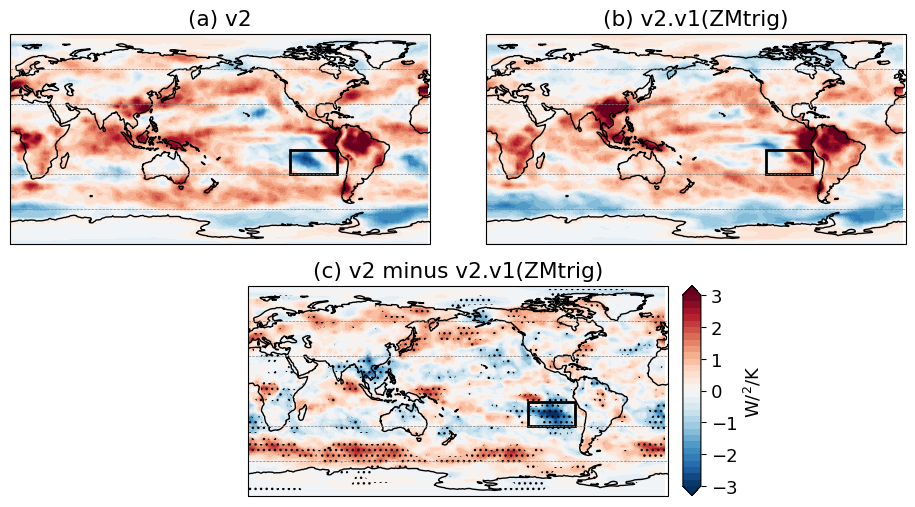

In [10]:
case_stamp = [\
'v2.OutTend',\
'v2.bk.trig',\
# 'v2.bk.trig.ZMout',\
]

VarsA = [
    ['netCRE_ano_grd_adj','net cloud feedback [W/m$^2$/K]',]
]

Vars = [svar[0] for svar in VarsA]
Vars_label = [svar[1] for svar in VarsA]

# ============== read data =====================
datadir = workdir+'diag_feedback_E3SM/data/'

dics = {}
dics_st = {} 
for icase,case in enumerate(case_stamp):
    fname = 'lat-lon-gfdbk-CMIP6-'+case+'.nc'
    f1 = xr.open_dataset(datadir+fname)
    dics[case] = {}
    for svar in Vars:
        data = f1[svar]
        print('data.shape=',data.shape)
        dics[case][svar] = data 
    f1.close()    
    
    # read anomaly for significant map 
    fname = 'lat-lon-gfdbk-anom-CMIP6-'+case+'.nc'
    f2 = xr.open_dataset(datadir+fname)
    dics_st[case] = {}
    for svar in Vars:
        data = f2[svar] 
        print('data.shape=',data.shape)
        dics_st[case][svar] = data 
    f2.close() 
    
        
        
print(dics.keys())
print()       
# ============== Spatial map =====================
# fig = plt.figure(figsize=(12,6))
# nrow = 2
# ncol = 2

fig = plt.figure(figsize=(12,6))
nrow = 2
ncol = 4

gs = GridSpec(nrow,ncol, figure=fig)

ii = 0 
for svar in Vars:

    datapA = [dics[case][svar] for case in dics.keys()]
    datapA.append(dics[case_stamp[0]][svar]-dics[case_stamp[1]][svar]) # append the difference 
    
    titleA = [case_stamp_out[icase] for icase,case in enumerate(dics.keys())]
    titleA.append(case_stamp_out[0]+' minus '+case_stamp_out[1])
    
    for ida,datap in enumerate(datapA):
                
        data2_avg = datap
        print(data2_avg.shape)
        
        if ida == 0:
            axx = gs[0,0:2]
        elif ida == 1:
            axx = gs[0,2:]
        else:
            axx = gs[1,1:3]
        ax = fig.add_subplot(axx,projection=ccrs.PlateCarree(180))
        lons = datap.lon
        lats = datap.lat
        im = ax.contourf(lons,lats,data2_avg,transform=ccrs.PlateCarree(),
                   levels = np.arange(-3,3.2,0.2),
                    cmap = 'RdBu_r',
                    # norm = norm, 
                    extend = 'both',
                   )
    

        ax.coastlines()
        ax.set_global()
        
        ax.set_title('('+chr(ord('`')+(ii+1))+') '+titleA[ii])
        
        # =============================================================
        # add significance in the difference map
        # =============================================================
        if ida == 2:
            x1 = dics_st[case_stamp[0]][svar] 
            x2 = dics_st[case_stamp[1]][svar]
            statres, pval = ttest_rel(x1,x2)  
            spy1 = np.where(pval < 0.05, 1, 0)
            ax.contourf(lons,lats,spy1, transform=ccrs.PlateCarree(),levels=[0.5,1.5],colors='none',hatches=['...','//'])  
        
        for yref in [-30,30,-60,60]:
            ax.axhline(y=yref,ls='--',c='grey',lw=0.5)
        
        # fig.colorbar(im,ax=ax,orientation='horizontal')
        
        if focus_region == 'TropMarineLow':
            # add box 
            lw = 2
            a2 = 0.3
            ax.add_patch(mpatches.Rectangle(xy=[240, -30], width=40, height=20,
                                       edgecolor='black',
                                       linewidth=lw,
                                       facecolor='none',
                                       alpha=1.0,
                                       transform=ccrs.PlateCarree())
                    )

        ii += 1


pos2 = [0.7, 0.11, 0.015, 0.35]    
fh = 13

cbar_ax = fig.add_axes(pos2)
cb = fig.colorbar(im,ax=ax, orientation='vertical', cax=cbar_ax)
cb.set_label('W/$^2$/K',fontsize=fh)
cb.ax.tick_params(labelsize=fh)
tick_locator = ticker.MaxNLocator(nbins=7)
cb.locator = tick_locator
cb.update_ticks()


fig.subplots_adjust(wspace=0.1)

# fig.tight_layout()

fig.savefig(figdir+'LatLon_'+Vars[-1]+'_'+tag+'_'+focus_region+'_'+dd+'.png',dpi=300,bbox_inches='tight')
fig.savefig(figdir+'LatLon_'+Vars[-1]+'_'+tag+'_'+focus_region+'_'+dd+'.pdf',bbox_inches='tight')

# Tendency

## define dict for variables

In [11]:
# ======= define dict for variables
dic_att = {}
for svar in ['DTCOND','DCCLDLIQ','DCQ','ZMDT','ZMDLIQ','ZMDQ','EVAPTZM','ZMMTT','MPDT','MPDLIQ','MPDQ','TTEND_CLUBB','RCMTEND_CLUBB','RVMTEND_CLUBB','QRL','QRS','DPDLFLIQ','DYN']:
    dic_att[svar] = {}
    if svar in ['DTCOND','DCCLDLIQ','DCQ']:
        dic_att[svar]['name'] = 'TotPhy'
        dic_att[svar]['color'] = 'tab:grey'
    if svar in ['ZMDT','ZMDLIQ','ZMDQ','EVAPTZM','ZMMTT']:
        dic_att[svar]['name'] = 'ZM'
        dic_att[svar]['color'] = 'tab:orange'
    if svar in ['MPDT','MPDLIQ','MPDQ']:
        dic_att[svar]['name'] = 'MP'
        dic_att[svar]['color'] = 'tab:green'
    if svar in ['TTEND_CLUBB','RCMTEND_CLUBB','RVMTEND_CLUBB']:
        dic_att[svar]['name'] = 'CLUBB'
        dic_att[svar]['color'] = 'tab:cyan'
    if svar == 'QRL':
        dic_att[svar]['name'] = 'LW'
        dic_att[svar]['color'] = 'tab:pink'
    if svar == 'QRS':
        dic_att[svar]['name'] = 'SW'
        dic_att[svar]['color'] = 'tab:olive'
    if svar == 'DPDLFLIQ':
        dic_att[svar]['name'] = 'ZMDetrain'
        dic_att[svar]['color'] = 'tab:red'
    if svar == 'DYN':
        dic_att[svar]['name'] = 'Dyn'
        dic_att[svar]['color'] = 'tab:grey'
 

## read data

In [12]:
focus_region = 'TropMarineLow'

case_stamp = [\
'v2.OutTend.ZMout',\
'v2.bk.trig.ZMout',\
]

cpair = 1.00464e3 #J/(kg K)


datadir = workdir+'diag_feedback_E3SM/data/'

# add the sum term to verify the conservation 
add_sumterm = False

plot_vars = ['T','Q','CLDLIQ']
# plot_vars = ['CLDLIQ']

dics = {}
for iplot,plot_var in enumerate(plot_vars):

    if plot_var == 'T':
        Vars = ['DTCOND','ZMDT','MPDT','TTEND_CLUBB','QRL','QRS']
    elif plot_var == 'CLDLIQ':
        Vars = ['DCCLDLIQ','ZMDLIQ','DPDLFLIQ','MPDLIQ','RCMTEND_CLUBB']
    elif plot_var == 'Q':
        # PTEQ == DCQ
        Vars = ['DCQ','ZMDQ','MPDQ','RVMTEND_CLUBB']

    dics[plot_var] = {}
    for svar in Vars:
        
        dics[plot_var][svar] = {} 
        for icase,case in enumerate(case_stamp):
            
            f1 = xr.open_dataset(datadir+'global_'+svar+'_'+case+'.nc')
            print(datadir+'global_'+svar+'_'+case+'.nc')
            data1 = f1[svar+'_pi_clim']
            data2 = f1[svar+'_ab_clim']
            data3 = f1[svar+'_ano_clim']

            f1.close()
        
            if svar == 'MPDT':
                scale = 1.0/cpair # kg/kg --> g/kg
            elif plot_var == 'T':
                scale = 86400.  # convert from K/s to K/day  
            elif plot_var == 'Q' or plot_var == 'CLDLIQ':
                scale = 86400.*1e3   # convert from kg/kg/s to g/kg/day 
            else:
                scale = 1.0 

            data1_cs = data1*scale
            data2_cs = data2*scale 
            
            dics[plot_var][svar][case] = []
            
            for data in [data1_cs,data2_cs]:
            
                # ensure the lat and lon names 
                latnew, lonnew = list(data.coords.keys())[0], list(data.coords.keys())[1]
                data = data.rename({lonnew: 'lon',latnew: 'lat'})

                _,_,data_avg,_,_,datam_avg,_ \
                    = v1v2.regime_partitioning(focus_region,omega700_pi_mm,omega700_ab_mm,omega700_avg_mm,data)                

                if focus_region == 'TropMarineLow' and do_spc_region:
                    dics[plot_var][svar][case].append(v1v2.area_averager(data_avg.sel(lat=slice(latS,latE),lon=slice(lonS,lonE))))
                else:
                    dics[plot_var][svar][case].append(v1v2.area_averager(data_avg))

        
    print(dics[plot_var].keys())

    # ====== calculate DYN term =======================
    if plot_var in ['T','Q']:
        dics[plot_var]['DYN'] = {}
        for exp in dics[plot_var][Vars[0]].keys():
            if plot_var == 'Q':
                dics[plot_var]['DYN'][exp] = [] 
                for ii in range(2):
                    dics[plot_var]['DYN'][exp].append(-1. * (dics[plot_var]['DCQ'][exp][ii]))
            if plot_var == 'T':
                dics[plot_var]['DYN'][exp] = [] 
                for ii in range(2):
                    dics[plot_var]['DYN'][exp].append(-1. * (dics[plot_var]['DTCOND'][exp][ii]+dics[plot_var]['QRL'][exp][ii]+dics[plot_var]['QRS'][exp][ii]))

    print(dics[plot_var].keys())

    # if add_sumterm:
    #     dics[plot_var]['SUM'] = {}
    #     for exp in dics[Vars[0]].keys():
    #         if plot_var == 'T':
    #             dics[plot_var]['SUM'][exp] = dics[plot_var]['ZMDT'][exp] + dics[plot_var]['EVAPTZM'][exp] + dics[plot_var]['ZMMTT'][exp] + dics[plot_var]['MPDT'][exp] + dics[plot_var]['TTEND_CLUBB'][exp]
    #         elif plot_var == 'CLDLIQ':
    #             dics[plot_var]['SUM'][exp] = dics[plot_var]['ZMDLIQ'][exp] + dics[plot_var]['MPDLIQ'][exp] + dics[plot_var]['RCMTEND_CLUBB'][exp] + dics[plot_var]['DPDLFLIQ'][exp]
    #         elif plot_var == 'Q':
    #             dics[plot_var]['SUM'][exp] = dics[plot_var]['ZMDQ'][exp] + dics[plot_var]['MPDQ'][exp] + dics[plot_var]['RVMTEND_CLUBB'][exp]

/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_DTCOND_v2.OutTend.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_DTCOND_v2.bk.trig.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_ZMDT_v2.OutTend.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_ZMDT_v2.bk.trig.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_MPDT_v2.OutTend.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_MPDT_v2.bk.trig.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_TTEND_CLUBB_v2.OutTend.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_TTEND_CLUBB_v2.bk.trig.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_QRL_v2.OutTend.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_QRL_v2.bk.trig.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_QRS_v2.OutTend.ZMout.nc
/home/qin4/From_Compy/home_d

## Figure 5 - cloud water tendency

plot_var= CLDLIQ


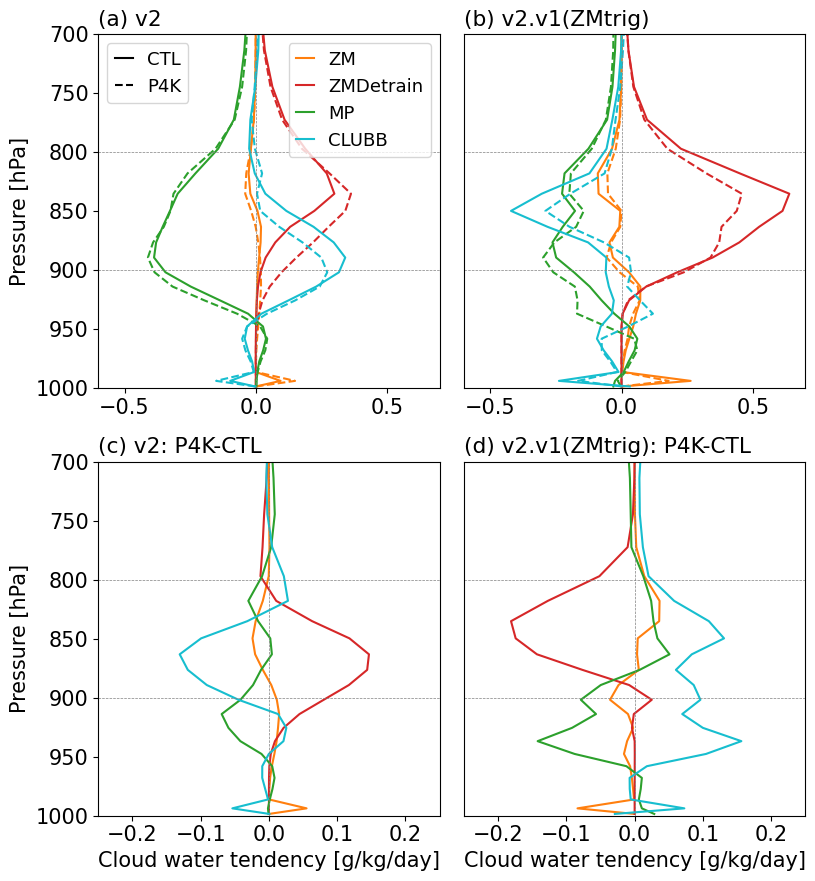

In [14]:
if focus_region == 'TropMarineLow':
    top_lev = 700
    # top_lev = 200
else:
    top_lev = 0 
    
#==================
nrow = 2
ncol = 3

fig = plt.figure(figsize=(ncol*4,9/2*nrow)) 

Varsp = ['CLDLIQ']
outfile = 'Profiles_Tendency_onlyCLDLIQ_'+focus_region+'_'+tag3+'_'+'TopLev-'+str(top_lev)+'_'+dd

for iplot,plot_var in enumerate(Varsp):
    print('plot_var=',plot_var)
    
    # get output name and color lists 
    Vars_out = [dic_att[svar]['name'] for svar in dics[plot_var].keys()]
    colorsA = [dic_att[svar]['color'] for svar in dics[plot_var].keys()]

    levs = data1_cs.coords['lev'].data
    marker = '.'
    
    # ========== plot case1 ===================================
    ax1 = fig.add_subplot(nrow,ncol,iplot+1)
    ax1d = fig.add_subplot(nrow,ncol,iplot+4)

    if plot_var in ['T','Q']:
        ivar = 1
        
    elif plot_var in ['CLDLIQ']:
        ivar = 1

    varlist = list(dics[plot_var].keys())[ivar:]
    varlist_out = Vars_out[ivar:]
    colors_h = colorsA[ivar:] 
        
    for ivar,svar in enumerate(varlist):
        label = varlist_out[ivar] 
        
        L1 = ax1.plot(np.array(dics[plot_var][svar][case_stamp[0]][0]),levs,ls='-',color=colors_h[ivar],label=label)

        L2 = ax1.plot(np.array(dics[plot_var][svar][case_stamp[0]][1]),levs,ls='--',color=colors_h[ivar],label='_nolegend_')
       
        dif = np.array(dics[plot_var][svar][case_stamp[0]][1]) - np.array(dics[plot_var][svar][case_stamp[0]][0])
        
        ax1d.plot(dif, levs, ls = '-', color=colors_h[ivar],label='P4K-CTL')
                                                                          
    if iplot == 0: 
        legend = ax1.legend([L1[0],L2[0]],['CTL','P4K'],loc='upper left')
        legend.legendHandles[0].set_color('black')
        legend.legendHandles[1].set_color('black')
        ax1.legend(loc='upper right')
        ax1.add_artist(legend)
    else:
        ax1.legend(loc='upper right')
    
    ax1.set_title('('+chr(ord('`')+(iplot+1))+') '+case_stamp_out[0].split('.')[0], loc='left')
    ax1d.set_title('('+chr(ord('`')+(iplot+3))+') '+case_stamp_out[0].split('.')[0]+': P4K-CTL', loc='left')
                                                                                                                          
    # ========== plot case2 ===================================
    if len(Varsp) == 1:
        offset = 2 
    else:
        offset = 4     
    ax2 = fig.add_subplot(nrow,ncol,iplot+offset)
    ax2d = fig.add_subplot(nrow,ncol,iplot+offset+3)
    
    if plot_var in ['T','Q']:
        ivar = 1
        
    elif plot_var in ['CLDLIQ']:
        ivar = 1

    varlist = list(dics[plot_var].keys())[ivar:]
    varlist_out = Vars_out[ivar:]
    colors_h = colorsA[ivar:] 
        
    for ivar,svar in enumerate(varlist):
        label = varlist_out[ivar] 
        
        L1 = ax2.plot(np.array(dics[plot_var][svar][case_stamp[1]][0]),levs,ls='-',color=colors_h[ivar],label=label)

        L2 = ax2.plot(np.array(dics[plot_var][svar][case_stamp[1]][1]),levs,ls='--',color=colors_h[ivar],label='_nolegend_')
    
        dif = np.array(dics[plot_var][svar][case_stamp[1]][1]) - np.array(dics[plot_var][svar][case_stamp[1]][0])
        ax2d.plot(dif, levs, ls='-',color=colors_h[ivar],label='_nolegend_')
        
#     if iplot == 0: 
#         legend = ax2.legend([L1[0],L2[0]],['CTL','P4K'],loc='upper left')
#         legend.legendHandles[0].set_color('black')
#         legend.legendHandles[1].set_color('black')
#         ax2.legend(loc='upper right')
#         ax2.add_artist(legend)
#     else:
#         ax2.legend(loc='upper right')
    
    ax2.set_title('('+chr(ord('`')+(iplot+offset))+') '+case_stamp_out[1], loc='left')    
    ax2d.set_title('('+chr(ord('`')+(iplot+offset+2))+') '+case_stamp_out[1]+': P4K-CTL', loc='left')
    
    # ========================== 
    ax1.set_ylabel('Pressure [hPa]')
    ax1d.set_ylabel('Pressure [hPa]')
    
    ax2.set_yticklabels([])
    ax2d.set_yticklabels([])

    for axx in [ax1,ax2,ax1d,ax2d]:
        axx.set_ylim((1000,top_lev))

        if plot_var == 'CLDLIQ':
            axx.set_xlim((-0.6,0.7))
            
            if axx in [ax1d,ax2d]:
                axx.set_xlim((-0.25,0.25))
                axx.set_xlabel('Cloud water tendency [g/kg/day]')
            if axx in [ax2,ax2d]:
                axx.set_yticks([])

        axx.axvline(x=0,ls='--',color='grey',lw=0.5)        
        axx.axhline(y=900,ls='--',color='grey',lw=0.5)
        axx.axhline(y=800,ls='--',color='grey',lw=0.5)

fig.tight_layout()

fig.savefig(figdir+outfile+'.png',dpi = 300, bbox_inches='tight')
fig.savefig(figdir+outfile+'.pdf', bbox_inches='tight') 

# Frequency vs In-cloud detrainment

Vars =  ['DPDLFLIQ', 'FREQZM', 'dlf_out']
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_DPDLFLIQ_v2.OutTend.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_DPDLFLIQ_v2.bk.trig.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_FREQZM_v2.OutTend.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_FREQZM_v2.bk.trig.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_dlf_out_v2.OutTend.ZMout.nc
/home/qin4/From_Compy/home_dir/diag_feedback_E3SM/data/global_dlf_out_v2.bk.trig.ZMout.nc
dict_keys(['DPDLFLIQ', 'FREQZM', 'dlf_out'])


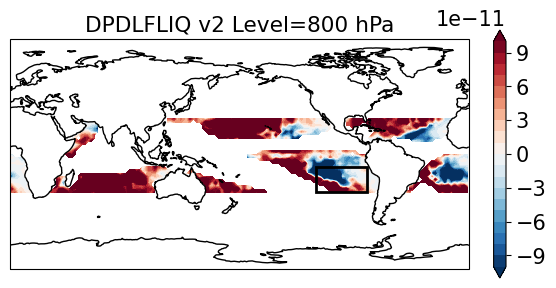

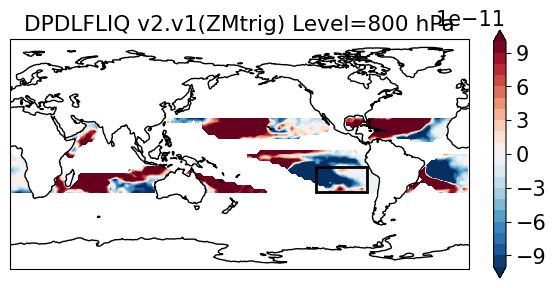

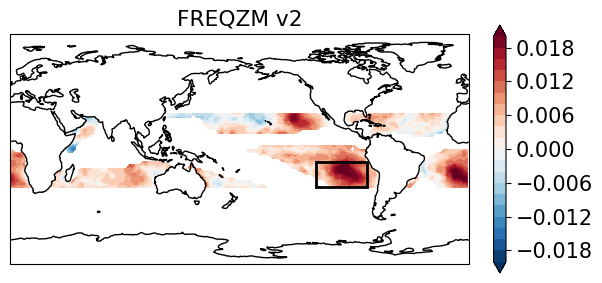

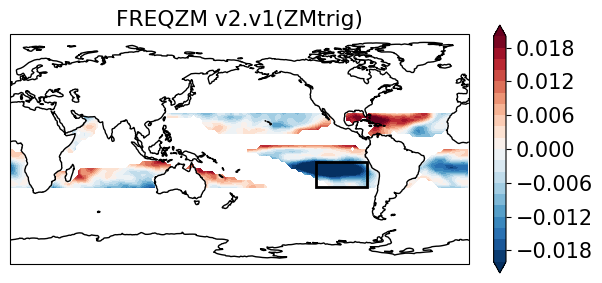

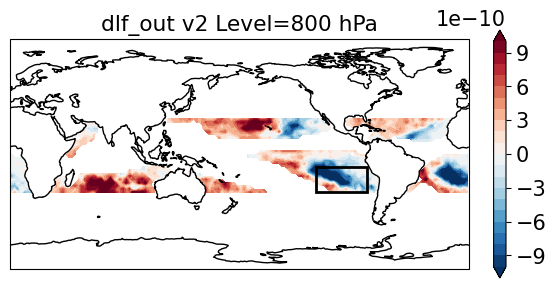

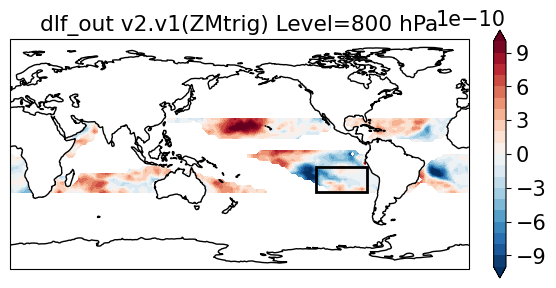

In [15]:
focus_region = 'TropMarineLow' # MarineLow, MidLat

if focus_region == 'TropMarineLow':
    top_lev = 700
else:
    top_lev = 0

case_stamp = [\
    'v2.OutTend.ZMout',\
    'v2.bk.trig.ZMout',\
    ]

case_stamp_out = [
    'v2',
    'v2.v1(ZMtrig)',
    # 'v1',
]

VarsA = [
    ['DPDLFLIQ','%','ZM\nDetrainment'],
    ['FREQZM','mg/kg','ZM\nFrequency'],
    ['dlf_out','%','ZM Detrainment\nwhen ZM is activated'],
]

Vars = [svar[0] for svar in VarsA]
Vars_units = [svar[1] for svar in VarsA] 
Vars_out = [svar[2] for svar in VarsA]

print('Vars = ',Vars)

# ================ read data ========================
datadir = workdir+'diag_feedback_E3SM/data/'

dics = {}
for svar in Vars:
    dics[svar] = {}
    for icase,case in enumerate(case_stamp):
        f1 = xr.open_dataset(datadir+'global_'+svar+'_'+case+'.nc')
        print(datadir+'global_'+svar+'_'+case+'.nc')
        data1 = f1[svar+'_pi_clim']
        data2 = f1[svar+'_ab_clim']
        data3 = f1[svar+'_ano_clim']
        
        dics[svar][case] = [] 
        ii = 0 
        for data in [data1,data2,data3]:
            
            # ensure the lat and lon names 
            latnew, lonnew = list(data.coords.keys())[0], list(data.coords.keys())[1]
            data = data.rename({lonnew: 'lon',latnew: 'lat'})

            _,_,data_avg,_,_,datam_avg,_ \
                = v1v2.regime_partitioning(focus_region,omega700_pi_mm,omega700_ab_mm,omega700_avg_mm,data)
            
            # ======== check spatial map of Frequency ========================
            # data_avg = data.sel(lat=slice(-20.5,-10.5),lon=slice(240.5,268,5))

            if len(data_avg.shape) == 2 and ii == 2:
                fig = plt.figure()
                ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(180))
                im = ax.contourf(data_avg.lon,data_avg.lat,data_avg,transform=ccrs.PlateCarree(),
                                 levels=np.arange(-2,2.2,0.2)*1e-2,
                                 cmap='RdBu_r',
                                 extend='both'
                            )
                ax.coastlines()
                ax.set_global()  
                ax.set_title(svar+' '+case_stamp_out[icase])
                
                fig.colorbar(im,ax=ax,fraction=0.025)
                
                # add box 
                lw = 2
                a2 = 0.3
                ax.add_patch(mpatches.Rectangle(xy=[240, -30], width=40, height=20,
                                           edgecolor='black',
                                           linewidth=lw,
                                           facecolor='none',
                                           alpha=1.0,
                                           transform=ccrs.PlateCarree())
                        )
                
            elif len(data_avg.shape) == 3 and ii == 2: 
                lev_spc = 800 
                
                if svar == 'dlf_out':
                    levels = np.arange(-1,1.1,0.1)*1e-9
                else:
                    levels = np.arange(-1,1.1,0.1)*1e-10
                
                fig = plt.figure()
                ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(180))
                im = ax.contourf(data_avg.lon,data_avg.lat,data_avg.sel(lev=lev_spc,method='nearest'),transform=ccrs.PlateCarree(),
                                 levels=levels,
                                 norm=mcolors.CenteredNorm(), 
                                 cmap='RdBu_r',
                                 extend='both'
                            )
                ax.coastlines()
                ax.set_global()  
                ax.set_title(svar+' '+case_stamp_out[icase]+' '+'Level='+str(lev_spc)+' hPa')
                
                fig.colorbar(im,ax=ax,fraction=0.025)
                
                # add box 
                lw = 2
                a2 = 0.3
                ax.add_patch(mpatches.Rectangle(xy=[240, -30], width=40, height=20,
                                           edgecolor='black',
                                           linewidth=lw,
                                           facecolor='none',
                                           alpha=1.0,
                                           transform=ccrs.PlateCarree())
                        )
            # ================================================================    
        
            if len(data_avg.shape) == 3: 
                if focus_region=='TropMarineLow' and do_spc_region:
                    tmp = v1v2.area_averager(data_avg.sel(lat=slice(latS,latE),lon=slice(lonS,lonE),lev=slice(1000,top_lev)))
                else:
                    tmp = v1v2.area_averager(data_avg.sel(lev=slice(1000,top_lev)))
            else:
                if focus_region=='TropMarineLow' and do_spc_region:
                    tmp = v1v2.area_averager(data_avg.sel(lat=slice(latS,latE),lon=slice(lonS,lonE)))
                else:
                    tmp = v1v2.area_averager(data_avg)
            
            # print(tmp.shape)
            # print(tmp.coords)
            
            dics[svar][case].append(tmp)
            
            ii += 1
                
print(dics.keys())

## Figure 6 - relative change

(21,) (21,)
()
DPDLFLIQ -3.088329146548578e-06 -4.185629143282238e-06 0.3553053915771797
DPDLFLIQ -6.874252833451478e-06 -5.453713325569655e-06 -0.20664638649442682
() ()
FREQZM 0.15867364839255998 0.2124055098049253 0.33863128475770743
FREQZM 0.34759997698340134 0.2667156517238629 -0.2326937014250747
(21,) (21,)
()
dlf_out -1.788279931713646e-05 -1.8305130298545985e-05 0.02361660352609458
dlf_out -1.8840535405577877e-05 -1.921390085210037e-05 0.01981713568564266


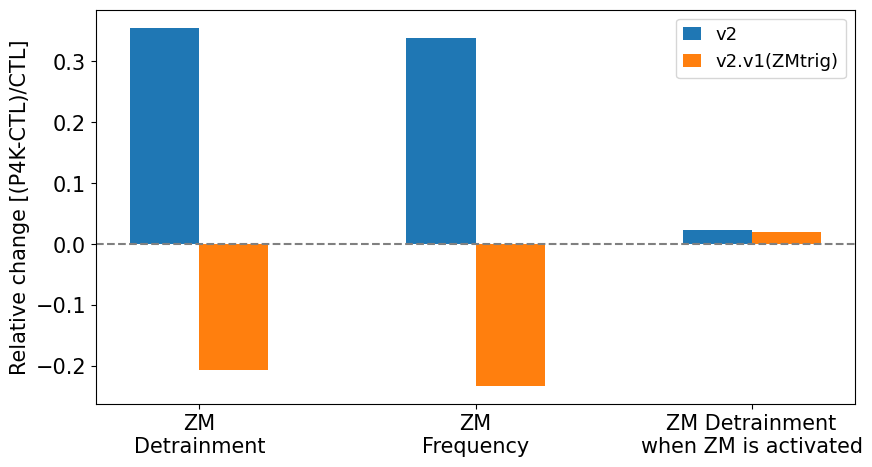

In [16]:
# start index for lev to skip these artificial 'zero' values in the upper level.
ilevS = 18 

ww = 0.25
ww2 = 0.25
c1 = 'tab:blue'
c2 = 'tab:orange'

plot_clim = False

fig1 = plt.figure(figsize=(9,9))
nrow = 2
ncol = 1
ax1 = fig1.add_subplot(nrow,ncol,2)

if plot_clim:
    ax2 = fig1.add_subplot(nrow,ncol,1)

for ivar,svar in enumerate(dics.keys()):
    [data1,data2,data21] = dics[svar][case_stamp[0]]
    [data3,data4,data43] = dics[svar][case_stamp[1]]
    print(data1.shape, data2.shape)
    
    # xid = data1.shape[0]+2

    if len(data1.shape) == 0: # Frequency 

        print(svar,np.nanmean(data1),np.nanmean(data2),(np.nanmean(data2)-np.nanmean(data1))/np.nanmean(data1))
        dd1 = (np.nanmean(data2)-np.nanmean(data1))/np.nanmean(data1) 
        ax1.bar(ivar,dd1,width=ww,color=c1)
        
        print(svar,np.nanmean(data3),np.nanmean(data4),(np.nanmean(data4)-np.nanmean(data3))/np.nanmean(data3))
        dd2 = (np.nanmean(data4)-np.nanmean(data3))/np.nanmean(data3) 
        ax1.bar(ivar+ww2,dd2,width=ww,color=c2)
        
        if plot_clim:
            ax2.bar(ivar,np.nanmean(data1),width=ww,color=c1)
            ax2.bar(ivar,np.nanmean(data2),width=ww,facecolor='none',edgecolor='black')

            ax2.bar(ivar+ww2,np.nanmean(data3),width=ww,color=c2)
            ax2.bar(ivar+ww2,np.nanmean(data4),width=ww,facecolor='none',edgecolor='black')

    else:
        # data1 = data1[ilevS:]
        # data2 = data2[ilevS:]
        # data3 = data3[ilevS:]
        # data4 = data4[ilevS:]
        
        try:
            levs = data1.lev.values
        except:
            levs = data1.ilev.values
            
        # print('levs=',levs)

        
        data1 = data1.where(data1!=0)
        data2 = data2.where(data2!=0)
        data3 = data3.where(data3!=0)
        data4 = data4.where(data4!=0)

        data1_wgt = v1v2.wgt_p_tp(data1,levs)
        data2_wgt = v1v2.wgt_p_tp(data2,levs)
        data3_wgt = v1v2.wgt_p_tp(data3,levs)
        data4_wgt = v1v2.wgt_p_tp(data4,levs)
        
        print(data1_wgt.shape)

        if svar not in ['DPDLFLIQ']:
            data1_wgt = np.where(data1_wgt==0,np.nan,data1_wgt)
            data2_wgt = np.where(data2_wgt==0,np.nan,data2_wgt)

            data3_wgt = np.where(data3_wgt==0,np.nan,data3_wgt)
            data4_wgt = np.where(data4_wgt==0,np.nan,data4_wgt)

        dd1 = (np.nanmean(data2_wgt)-np.nanmean(data1_wgt))/np.nanmean(data1_wgt)
        L1 = ax1.bar(ivar,dd1,width=ww,color=c1)
        print(svar,np.nanmean(data1_wgt), np.nanmean(data2_wgt), dd1)
       
        dd2 = (np.nanmean(data4_wgt)-np.nanmean(data3_wgt))/np.nanmean(data3_wgt)
        L2 = ax1.bar(ivar+ww2,dd2,width=ww,color=c2)
        print(svar,np.nanmean(data3_wgt), np.nanmean(data4_wgt), dd2)
        
        if plot_clim:
            ax2.bar(ivar,np.nanmean(data1_wgt)*1e5,width=ww,color=c1)
            ax2.bar(ivar,np.nanmean(data2_wgt)*1e5,width=ww,facecolor='none',edgecolor='black')
            print(ivar, np.nanmean(data1_wgt), np.nanmean(data2_wgt))

            ax2.bar(ivar+ww2,np.nanmean(data3_wgt)*1e5,width=ww,color=c2)
            ax2.bar(ivar+ww2,np.nanmean(data4_wgt)*1e5,width=ww,facecolor='none',edgecolor='black')

        ax1.legend([L1,L2],case_stamp_out)

    # ax1.set_title(svar)

ax1.set_xticks(np.arange(len(dics.keys()))+ww2/2)
ax1.set_xticklabels(Vars_out,rotation=0)

ax1.set_xticks(np.arange(len(dics.keys()))+ww2/2)
ax1.set_xticklabels(Vars_out,rotation=0)

# ax1.set_title('Vertically Integerated from 1000 to 700 hPa')

ax1.axhline(y=0,ls='--',color='grey')

# ax1.axvline(x=2.6,ls='--',color='grey')

ax1.set_ylabel('Relative change [(P4K-CTL)/CTL]')

# ax1.grid(axis='y',ls=':')

fig1.tight_layout()
fig1.savefig(figdir+'Barplot_ZMout_'+Vars[-1]+'_FixedRegime_'+focus_region+'_'+tag3+'_'+dd+'.png',dpi=300,bbox_inches='tight')
fig1.savefig(figdir+'Barplot_ZMout_'+Vars[-1]+'_FixedRegime_'+focus_region+'_'+tag3+'_'+dd+'.pdf',bbox_inches='tight')
